# Investigating number of layers for different instances

In [13]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

node_size = 6
MAX_LAYERS = 20
MAX_FEVAL = 1000
graph_type = "Uniform Random"

In [14]:
import os
import logging
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut

# Custom imports
from haqc.generators.graph_instance import create_graphs_from_all_sources
from haqc.exp_utils import to_snake_case
from haqc.features.graph_features import get_graph_features
from haqc.generators.parameter import get_optimal_parameters
from haqc.solutions.solutions import compute_max_cut_brute_force
from haqc.initialisation.initialisation import Initialisation
from haqc.plot.utils import *

# Logger setup
logging.basicConfig(
    level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s'
)
qiskit_logger = logging.getLogger('qiskit')
qiskit_logger.setLevel(logging.ERROR)  # or use logging.CRITICAL
logging.info('Script started')


2024-01-26 16:41:25,542 - INFO - Script started


In [15]:
# Check that optimal parameters csv file exists
if not os.path.exists('../data/optimal-parameters.csv'):
    raise FileNotFoundError('Optimal parameters csv file not found.')

# Load the optimal parameters DataFrame from the csv file
df = pd.read_csv('../data/optimal-parameters.csv')
df.head()

,Source,params.n_layers,median_beta_1,median_gamma_1,median_beta_2,median_gamma_2,median_beta_3,median_gamma_3,median_beta_4,median_gamma_4,median_beta_5,median_gamma_5
0,four_regular_graph,1,-0.298606,-0.455742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,geometric,1,0.218053,-0.229041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nearly_complete_bi_partite,1,-0.336615,0.410319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,power_law_tree,1,0.392695,0.789341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,three_regular_graph,1,0.260689,-0.570326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Generate all graph sources
G_instances = create_graphs_from_all_sources(instance_size=node_size, sources="ALL")
G_instances = [g for g in G_instances if g.graph_type == graph_type]
graph_instance = G_instances[0]
G = graph_instance.G

print(
    f"\n{'-'*10} This run is for a {graph_instance.graph_type} graph with {len(G.nodes())} nodes  {'-'*10}\n"
)
# Show instance features
graph_features = get_graph_features(graph_instance.G)
instance_class = to_snake_case(graph_instance.graph_type)
graph_features = {str(key): val for key, val in graph_features.items()}
print(f"Graph Features {json.dumps(graph_features, indent=2)}")

Guess 1 for producing a connected Geometric Graph with r=0.5714769540831102 - connected: True

---------- This run is for a Uniform Random graph with 6 nodes  ----------

Graph Features {
  "acyclic": false,
  "algebraic_connectivity": 0.721586390503555,
  "average_distance": 1.6666666666666667,
  "bipartite": false,
  "clique_number": 3,
  "connected": true,
  "density": 0.4666666666666667,
  "diameter": 3,
  "edge_connectivity": 1,
  "eulerian": false,
  "laplacian_largest_eigenvalue": 4.891219848710295,
  "maximum_degree": 3,
  "minimum_degree": 1,
  "minimum_dominating_set": 2,
  "number_of_components": 1,
  "number_of_edges": 7,
  "number_of_vertices": 6,
  "planar": true,
  "radius": 2,
  "regular": false,
  "laplacian_second_largest_eigenvalue": 0.7215863905035546,
  "ratio_of_two_largest_laplacian_eigenvaleus": 6.778425858748511,
  "smallest_eigenvalue": -1.1102230246251565e-16,
  "vertex_connectivity": 1,
  "number_of_cut_vertices": 1,
  "number_of_minimal_odd_cycles": 1,
  "g

<class 'networkx.utils.decorators.argmap'> compilation 48:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [17]:
# Generate the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()

# Brute Force Solution for Max-Cut Problem
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)
print(f"MAXCUT Paritition: {max_cut_partition}")
print(f"MAXCUT Value: {max_cut_value}")


---------- Solving for Exact Ground State ----------

MAXCUT Paritition: (2, 4)
MAXCUT Value: 6


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_64324/2359658765.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


In [18]:
# Visualization code here...
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")
exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=qubitOp)
print(f"Minimum Energy is {exact_result}")


---------- Solving for Exact Ground State ----------

Minimum Energy is {   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': (-2.5+0j)}


In [19]:
# Iniitalisation of algorithms
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)
init_type = 'QIBPI'
results_df = pd.DataFrame(columns=['algo', 'init_type', 'eval_count', 'parameters', 'energy', 'std'])
results_df.head()

,algo,init_type,eval_count,parameters,energy,std


In [20]:
for layer in range(1, MAX_LAYERS+1):
    print(f"{'-'*15} Solving for layer: {layer} {'-'*15}")
    initial_point = Initialisation().random_initialisation(layer)
        
    # Callback function to store intermediate values
    intermediate_values = []
    total_feval = 0
    n_restart = 0
    
    while total_feval < MAX_FEVAL:
        print(f"{' '*5 + '-'*10} Solving at restart: {n_restart} {'-'*15}")
        
        def store_intermediate_result(eval_count, parameters, mean, std):
            if eval_count % 100 == 0:
                logging.info(
                    f"{type(NELDER_MEAD()).__name__} iteration {eval_count} \t cost function {mean}"
                )
            betas = parameters[:layer]  # Extracting beta values
            gammas = parameters[layer:]  # Extracting gamma values
            intermediate_values.append(
                {
                    'eval_count': eval_count,
                    'parameters': {'gammas': gammas, 'betas': betas},
                    'mean': mean,
                    'std': std,
                }
            )

        qaoa = QAOA(
            # Optimize only from the remaining  budget 
            optimizer=NELDER_MEAD(maxfev=MAX_FEVAL-total_feval),
            reps=layer,
            initial_point=initial_point,
            callback=store_intermediate_result,
            quantum_instance=quantum_instance,
            include_custom=True,
        )

        algo_result = qaoa.compute_minimum_eigenvalue(qubitOp)

        # Compute performance metrics
        eval_counts = [
            intermediate_result['eval_count']
            for intermediate_result in intermediate_values
        ]
        
        total_feval += eval_counts[-1]
        
        initial_point = Initialisation().random_initialisation(layer)
        
        n_restart += 1

    # Compile results into a dataframe from intermediate values
    results_df = results_df.append(
        pd.DataFrame(
            {
                'algo': [layer] * len(intermediate_values),
                'optimizer_name': [type(NELDER_MEAD()).__name__] * len(intermediate_values),
                'eval_count': [
                    i + 1
                    for i in range(total_feval)
                ],
                'parameters': [
                    intermediate_result['parameters']
                    for intermediate_result in intermediate_values
                ],
                'energy': [
                    intermediate_result['mean']
                    for intermediate_result in intermediate_values
                ],
                'std': [
                    intermediate_result['std']
                    for intermediate_result in intermediate_values
                ],
            }
        )
    )


--------------- Solving for layer: 1 ---------------
     ---------- Solving at restart: 0 ---------------
     ---------- Solving at restart: 1 ---------------
     ---------- Solving at restart: 2 ---------------
     ---------- Solving at restart: 3 ---------------
     ---------- Solving at restart: 4 ---------------
     ---------- Solving at restart: 5 ---------------
     ---------- Solving at restart: 6 ---------------
     ---------- Solving at restart: 7 ---------------
     ---------- Solving at restart: 8 ---------------
     ---------- Solving at restart: 9 ---------------
     ---------- Solving at restart: 10 ---------------
     ---------- Solving at restart: 11 ---------------
     ---------- Solving at restart: 12 ---------------
     ---------- Solving at restart: 13 ---------------
     ---------- Solving at restart: 14 ---------------


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_64324/4201195641.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(


--------------- Solving for layer: 2 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:32,247 - INFO - NELDER_MEAD iteration 100 	 cost function -1.514601361271469
2024-01-26 16:41:32,509 - INFO - NELDER_MEAD iteration 200 	 cost function -1.6819872384089638
2024-01-26 16:41:32,813 - INFO - NELDER_MEAD iteration 300 	 cost function -1.6933842642787376


     ---------- Solving at restart: 1 ---------------


2024-01-26 16:41:33,275 - INFO - NELDER_MEAD iteration 100 	 cost function -1.3608994605266236


     ---------- Solving at restart: 2 ---------------


2024-01-26 16:41:33,966 - INFO - NELDER_MEAD iteration 100 	 cost function -1.5560869980260015
2024-01-26 16:41:34,192 - INFO - NELDER_MEAD iteration 200 	 cost function -1.6933815517891415


     ---------- Solving at restart: 3 ---------------


2024-01-26 16:41:34,870 - INFO - NELDER_MEAD iteration 100 	 cost function -0.8359192548901122
2024-01-26 16:41:35,135 - INFO - NELDER_MEAD iteration 200 	 cost function -0.8369362370510894
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_64324/4201195641.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(


     ---------- Solving at restart: 4 ---------------
--------------- Solving for layer: 3 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:35,809 - INFO - NELDER_MEAD iteration 100 	 cost function -1.630157345880874
2024-01-26 16:41:36,158 - INFO - NELDER_MEAD iteration 200 	 cost function -1.89144541080166
2024-01-26 16:41:36,481 - INFO - NELDER_MEAD iteration 300 	 cost function -1.8919838106192064
2024-01-26 16:41:36,755 - INFO - NELDER_MEAD iteration 400 	 cost function -1.8920820228377673
2024-01-26 16:41:37,038 - INFO - NELDER_MEAD iteration 500 	 cost function -1.8957994319456373
2024-01-26 16:41:37,341 - INFO - NELDER_MEAD iteration 600 	 cost function -1.9012135411317388
2024-01-26 16:41:37,689 - INFO - NELDER_MEAD iteration 700 	 cost function -1.901279548489896


     ---------- Solving at restart: 1 ---------------


2024-01-26 16:41:38,199 - INFO - NELDER_MEAD iteration 100 	 cost function -1.8017916621750407
2024-01-26 16:41:38,661 - INFO - NELDER_MEAD iteration 200 	 cost function -1.82007672130799
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_64324/4201195641.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(


--------------- Solving for layer: 4 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:39,470 - INFO - NELDER_MEAD iteration 100 	 cost function -1.7586978480233812
2024-01-26 16:41:39,886 - INFO - NELDER_MEAD iteration 200 	 cost function -2.06867804488561
2024-01-26 16:41:40,261 - INFO - NELDER_MEAD iteration 300 	 cost function -2.119801824148742
2024-01-26 16:41:40,634 - INFO - NELDER_MEAD iteration 400 	 cost function -2.135337362158851
2024-01-26 16:41:41,026 - INFO - NELDER_MEAD iteration 500 	 cost function -2.1451478960056236
2024-01-26 16:41:41,510 - INFO - NELDER_MEAD iteration 600 	 cost function -2.1637694255050777
2024-01-26 16:41:41,837 - INFO - NELDER_MEAD iteration 700 	 cost function -2.1689765836502826
2024-01-26 16:41:42,202 - INFO - NELDER_MEAD iteration 800 	 cost function -2.169287556522585
2024-01-26 16:41:42,587 - INFO - NELDER_MEAD iteration 900 	 cost function -2.1716059931103358
2024-01-26 16:41:42,962 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.1874584433707334
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipyke

--------------- Solving for layer: 5 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:43,606 - INFO - NELDER_MEAD iteration 100 	 cost function -0.8368314676789271
2024-01-26 16:41:44,014 - INFO - NELDER_MEAD iteration 200 	 cost function -1.0292592765121689
2024-01-26 16:41:44,427 - INFO - NELDER_MEAD iteration 300 	 cost function -1.119669175565507
2024-01-26 16:41:44,815 - INFO - NELDER_MEAD iteration 400 	 cost function -1.5253240282395886
2024-01-26 16:41:45,249 - INFO - NELDER_MEAD iteration 500 	 cost function -1.6885677827481933
2024-01-26 16:41:45,748 - INFO - NELDER_MEAD iteration 600 	 cost function -1.7072490755241694
2024-01-26 16:41:46,127 - INFO - NELDER_MEAD iteration 700 	 cost function -1.7084301312888952
2024-01-26 16:41:46,527 - INFO - NELDER_MEAD iteration 800 	 cost function -1.7086965100082256
2024-01-26 16:41:46,945 - INFO - NELDER_MEAD iteration 900 	 cost function -1.709420628680374
2024-01-26 16:41:47,332 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.712526545395126
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

--------------- Solving for layer: 6 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:48,020 - INFO - NELDER_MEAD iteration 100 	 cost function -1.4623213275367166
2024-01-26 16:41:48,479 - INFO - NELDER_MEAD iteration 200 	 cost function -1.719265895007875
2024-01-26 16:41:48,957 - INFO - NELDER_MEAD iteration 300 	 cost function -1.7821182562530729
2024-01-26 16:41:49,386 - INFO - NELDER_MEAD iteration 400 	 cost function -1.9473260714450737
2024-01-26 16:41:49,830 - INFO - NELDER_MEAD iteration 500 	 cost function -2.1227100418855622
2024-01-26 16:41:50,249 - INFO - NELDER_MEAD iteration 600 	 cost function -2.195019560843779
2024-01-26 16:41:50,672 - INFO - NELDER_MEAD iteration 700 	 cost function -2.2077849223043065
2024-01-26 16:41:51,131 - INFO - NELDER_MEAD iteration 800 	 cost function -2.2213761770627105
2024-01-26 16:41:51,630 - INFO - NELDER_MEAD iteration 900 	 cost function -2.230459332933871
2024-01-26 16:41:52,084 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.2336126419422015
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

--------------- Solving for layer: 7 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:52,749 - INFO - NELDER_MEAD iteration 100 	 cost function -1.2883503447695925
2024-01-26 16:41:53,241 - INFO - NELDER_MEAD iteration 200 	 cost function -1.8532639171027212
2024-01-26 16:41:53,720 - INFO - NELDER_MEAD iteration 300 	 cost function -2.118908687714329
2024-01-26 16:41:54,251 - INFO - NELDER_MEAD iteration 400 	 cost function -2.207987067479359
2024-01-26 16:41:54,708 - INFO - NELDER_MEAD iteration 500 	 cost function -2.238939824423102
2024-01-26 16:41:55,154 - INFO - NELDER_MEAD iteration 600 	 cost function -2.258369349888299
2024-01-26 16:41:55,604 - INFO - NELDER_MEAD iteration 700 	 cost function -2.2633784846631686
2024-01-26 16:41:56,044 - INFO - NELDER_MEAD iteration 800 	 cost function -2.268189461884937
2024-01-26 16:41:56,498 - INFO - NELDER_MEAD iteration 900 	 cost function -2.270134458114118
2024-01-26 16:41:56,962 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.2732168551775436
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipyker

--------------- Solving for layer: 8 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:41:57,670 - INFO - NELDER_MEAD iteration 100 	 cost function -0.4727412610413745
2024-01-26 16:41:58,262 - INFO - NELDER_MEAD iteration 200 	 cost function -0.611971263071974
2024-01-26 16:41:58,791 - INFO - NELDER_MEAD iteration 300 	 cost function -1.2291319766028217
2024-01-26 16:41:59,305 - INFO - NELDER_MEAD iteration 400 	 cost function -1.5388598576349977
2024-01-26 16:41:59,870 - INFO - NELDER_MEAD iteration 500 	 cost function -1.7302170175146294
2024-01-26 16:42:00,386 - INFO - NELDER_MEAD iteration 600 	 cost function -1.7754469881546324
2024-01-26 16:42:00,877 - INFO - NELDER_MEAD iteration 700 	 cost function -1.8009576042198363
2024-01-26 16:42:01,385 - INFO - NELDER_MEAD iteration 800 	 cost function -1.8439371315045925
2024-01-26 16:42:01,910 - INFO - NELDER_MEAD iteration 900 	 cost function -1.858127299815633
2024-01-26 16:42:02,494 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.8781121347762548
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ip

--------------- Solving for layer: 9 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:03,297 - INFO - NELDER_MEAD iteration 100 	 cost function -1.1795549201545117
2024-01-26 16:42:03,852 - INFO - NELDER_MEAD iteration 200 	 cost function -1.9114963423499507
2024-01-26 16:42:04,466 - INFO - NELDER_MEAD iteration 300 	 cost function -2.0473825753616417
2024-01-26 16:42:05,019 - INFO - NELDER_MEAD iteration 400 	 cost function -2.125926499412902
2024-01-26 16:42:05,569 - INFO - NELDER_MEAD iteration 500 	 cost function -2.1340322019376377
2024-01-26 16:42:06,139 - INFO - NELDER_MEAD iteration 600 	 cost function -2.1495567466776886
2024-01-26 16:42:06,670 - INFO - NELDER_MEAD iteration 700 	 cost function -2.1553171308011576
2024-01-26 16:42:07,342 - INFO - NELDER_MEAD iteration 800 	 cost function -2.1727584463441936
2024-01-26 16:42:07,908 - INFO - NELDER_MEAD iteration 900 	 cost function -2.179340207207148
2024-01-26 16:42:08,450 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.1957497661556338
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ip

--------------- Solving for layer: 10 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:09,403 - INFO - NELDER_MEAD iteration 100 	 cost function -1.0672356102438334
2024-01-26 16:42:09,999 - INFO - NELDER_MEAD iteration 200 	 cost function -1.6146307417678152
2024-01-26 16:42:10,603 - INFO - NELDER_MEAD iteration 300 	 cost function -1.7720340702270718
2024-01-26 16:42:11,215 - INFO - NELDER_MEAD iteration 400 	 cost function -1.866488711586602
2024-01-26 16:42:11,808 - INFO - NELDER_MEAD iteration 500 	 cost function -1.8886867229269568
2024-01-26 16:42:12,430 - INFO - NELDER_MEAD iteration 600 	 cost function -1.9091824789051022
2024-01-26 16:42:13,017 - INFO - NELDER_MEAD iteration 700 	 cost function -1.9328744530472872
2024-01-26 16:42:13,665 - INFO - NELDER_MEAD iteration 800 	 cost function -1.9449595498675205
2024-01-26 16:42:14,331 - INFO - NELDER_MEAD iteration 900 	 cost function -1.9937179274932677
2024-01-26 16:42:15,014 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.0218344722093096
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/i

--------------- Solving for layer: 11 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:16,048 - INFO - NELDER_MEAD iteration 100 	 cost function -1.387142966894097
2024-01-26 16:42:16,843 - INFO - NELDER_MEAD iteration 200 	 cost function -1.780936010852059
2024-01-26 16:42:17,550 - INFO - NELDER_MEAD iteration 300 	 cost function -2.0681844870961887
2024-01-26 16:42:18,210 - INFO - NELDER_MEAD iteration 400 	 cost function -2.1370856224800936
2024-01-26 16:42:18,862 - INFO - NELDER_MEAD iteration 500 	 cost function -2.1630141467864332
2024-01-26 16:42:19,528 - INFO - NELDER_MEAD iteration 600 	 cost function -2.182070352033288
2024-01-26 16:42:20,192 - INFO - NELDER_MEAD iteration 700 	 cost function -2.196513414577516
2024-01-26 16:42:20,818 - INFO - NELDER_MEAD iteration 800 	 cost function -2.2582349931898698
2024-01-26 16:42:21,471 - INFO - NELDER_MEAD iteration 900 	 cost function -2.270487141742186
2024-01-26 16:42:22,135 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.2771944026054842
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipyke

--------------- Solving for layer: 12 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:23,301 - INFO - NELDER_MEAD iteration 100 	 cost function -0.7644213620604488
2024-01-26 16:42:24,003 - INFO - NELDER_MEAD iteration 200 	 cost function -1.1687330067388872
2024-01-26 16:42:24,714 - INFO - NELDER_MEAD iteration 300 	 cost function -1.5954744754082006
2024-01-26 16:42:25,475 - INFO - NELDER_MEAD iteration 400 	 cost function -1.9972237545861429
2024-01-26 16:42:26,163 - INFO - NELDER_MEAD iteration 500 	 cost function -2.131700726854199
2024-01-26 16:42:26,932 - INFO - NELDER_MEAD iteration 600 	 cost function -2.1956400391820576
2024-01-26 16:42:27,618 - INFO - NELDER_MEAD iteration 700 	 cost function -2.2287967771113886
2024-01-26 16:42:28,364 - INFO - NELDER_MEAD iteration 800 	 cost function -2.2572969072827167
2024-01-26 16:42:29,053 - INFO - NELDER_MEAD iteration 900 	 cost function -2.2673437057893846
2024-01-26 16:42:29,757 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.274942811404828
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ip

--------------- Solving for layer: 13 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:30,907 - INFO - NELDER_MEAD iteration 100 	 cost function -0.6298613275195215
2024-01-26 16:42:31,678 - INFO - NELDER_MEAD iteration 200 	 cost function -0.9461164652647402
2024-01-26 16:42:32,416 - INFO - NELDER_MEAD iteration 300 	 cost function -1.400726768706619
2024-01-26 16:42:33,264 - INFO - NELDER_MEAD iteration 400 	 cost function -1.485857585704269
2024-01-26 16:42:34,008 - INFO - NELDER_MEAD iteration 500 	 cost function -1.6467831137403801
2024-01-26 16:42:34,744 - INFO - NELDER_MEAD iteration 600 	 cost function -1.7166779540444725
2024-01-26 16:42:35,550 - INFO - NELDER_MEAD iteration 700 	 cost function -1.7591495394336043
2024-01-26 16:42:36,299 - INFO - NELDER_MEAD iteration 800 	 cost function -1.797982178567238
2024-01-26 16:42:37,090 - INFO - NELDER_MEAD iteration 900 	 cost function -1.8741577623849714
2024-01-26 16:42:37,816 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.9361097547178385
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

--------------- Solving for layer: 14 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:38,981 - INFO - NELDER_MEAD iteration 100 	 cost function -0.7960901329358986
2024-01-26 16:42:39,801 - INFO - NELDER_MEAD iteration 200 	 cost function -1.3630599783365702
2024-01-26 16:42:40,567 - INFO - NELDER_MEAD iteration 300 	 cost function -1.6303300681042026
2024-01-26 16:42:41,365 - INFO - NELDER_MEAD iteration 400 	 cost function -1.7424594958300077
2024-01-26 16:42:42,191 - INFO - NELDER_MEAD iteration 500 	 cost function -1.779913879157367
2024-01-26 16:42:42,961 - INFO - NELDER_MEAD iteration 600 	 cost function -1.846814559610391
2024-01-26 16:42:43,788 - INFO - NELDER_MEAD iteration 700 	 cost function -1.8771175728073228
2024-01-26 16:42:44,565 - INFO - NELDER_MEAD iteration 800 	 cost function -1.8918027712014993
2024-01-26 16:42:45,396 - INFO - NELDER_MEAD iteration 900 	 cost function -1.9020919583751543
2024-01-26 16:42:46,159 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.914880718034564
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

--------------- Solving for layer: 15 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:47,585 - INFO - NELDER_MEAD iteration 100 	 cost function -0.3250916091842335
2024-01-26 16:42:48,408 - INFO - NELDER_MEAD iteration 200 	 cost function -1.029474741984933
2024-01-26 16:42:49,292 - INFO - NELDER_MEAD iteration 300 	 cost function -1.131819198463512
2024-01-26 16:42:50,184 - INFO - NELDER_MEAD iteration 400 	 cost function -1.2446319150536629
2024-01-26 16:42:51,032 - INFO - NELDER_MEAD iteration 500 	 cost function -1.3367339740285669
2024-01-26 16:42:52,014 - INFO - NELDER_MEAD iteration 600 	 cost function -1.52364182479871
2024-01-26 16:42:52,903 - INFO - NELDER_MEAD iteration 700 	 cost function -1.6053444043641818
2024-01-26 16:42:53,768 - INFO - NELDER_MEAD iteration 800 	 cost function -1.633429604127556
2024-01-26 16:42:54,674 - INFO - NELDER_MEAD iteration 900 	 cost function -1.663148956243955
2024-01-26 16:42:55,550 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.6831550357570335
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipyker

--------------- Solving for layer: 16 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:42:56,887 - INFO - NELDER_MEAD iteration 100 	 cost function -0.18839526391072317
2024-01-26 16:42:57,801 - INFO - NELDER_MEAD iteration 200 	 cost function -0.6231068098637824
2024-01-26 16:42:58,727 - INFO - NELDER_MEAD iteration 300 	 cost function -1.2619869294277213
2024-01-26 16:42:59,607 - INFO - NELDER_MEAD iteration 400 	 cost function -1.5157000311037268
2024-01-26 16:43:00,561 - INFO - NELDER_MEAD iteration 500 	 cost function -1.625456783231395
2024-01-26 16:43:01,529 - INFO - NELDER_MEAD iteration 600 	 cost function -1.6943563619376358
2024-01-26 16:43:02,367 - INFO - NELDER_MEAD iteration 700 	 cost function -1.7665978125511965
2024-01-26 16:43:03,207 - INFO - NELDER_MEAD iteration 800 	 cost function -1.862516021064771
2024-01-26 16:43:04,134 - INFO - NELDER_MEAD iteration 900 	 cost function -2.019966289160647
2024-01-26 16:43:04,998 - INFO - NELDER_MEAD iteration 1000 	 cost function -2.0595539024324276
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ip

--------------- Solving for layer: 17 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:43:06,380 - INFO - NELDER_MEAD iteration 100 	 cost function -0.2150005929916763
2024-01-26 16:43:07,358 - INFO - NELDER_MEAD iteration 200 	 cost function -0.9116578953551746
2024-01-26 16:43:08,385 - INFO - NELDER_MEAD iteration 300 	 cost function -1.083119108628098
2024-01-26 16:43:09,291 - INFO - NELDER_MEAD iteration 400 	 cost function -1.2668135078718619
2024-01-26 16:43:10,143 - INFO - NELDER_MEAD iteration 500 	 cost function -1.3578309541582407
2024-01-26 16:43:11,104 - INFO - NELDER_MEAD iteration 600 	 cost function -1.4200901232410703
2024-01-26 16:43:12,012 - INFO - NELDER_MEAD iteration 700 	 cost function -1.494630752457379
2024-01-26 16:43:12,986 - INFO - NELDER_MEAD iteration 800 	 cost function -1.610052732314239
2024-01-26 16:43:14,030 - INFO - NELDER_MEAD iteration 900 	 cost function -1.8017723194606903
2024-01-26 16:43:14,914 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.9586993874192484
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

--------------- Solving for layer: 18 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:43:16,404 - INFO - NELDER_MEAD iteration 100 	 cost function -0.6653067152549381
2024-01-26 16:43:17,471 - INFO - NELDER_MEAD iteration 200 	 cost function -1.2052117020275117
2024-01-26 16:43:18,533 - INFO - NELDER_MEAD iteration 300 	 cost function -1.2282989850966795
2024-01-26 16:43:19,513 - INFO - NELDER_MEAD iteration 400 	 cost function -1.396789124740164
2024-01-26 16:43:20,464 - INFO - NELDER_MEAD iteration 500 	 cost function -1.4747152616808497
2024-01-26 16:43:21,486 - INFO - NELDER_MEAD iteration 600 	 cost function -1.6160218560467694
2024-01-26 16:43:22,512 - INFO - NELDER_MEAD iteration 700 	 cost function -1.6572027119839896
2024-01-26 16:43:23,479 - INFO - NELDER_MEAD iteration 800 	 cost function -1.7031402502155943
2024-01-26 16:43:24,457 - INFO - NELDER_MEAD iteration 900 	 cost function -1.7111466022091009
2024-01-26 16:43:25,451 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.7433125772751625
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/i

--------------- Solving for layer: 19 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:43:26,929 - INFO - NELDER_MEAD iteration 100 	 cost function -0.7406182732899196
2024-01-26 16:43:28,016 - INFO - NELDER_MEAD iteration 200 	 cost function -0.8602450857881355
2024-01-26 16:43:29,084 - INFO - NELDER_MEAD iteration 300 	 cost function -0.9418267045493716
2024-01-26 16:43:30,093 - INFO - NELDER_MEAD iteration 400 	 cost function -1.046222607158989
2024-01-26 16:43:31,139 - INFO - NELDER_MEAD iteration 500 	 cost function -1.2442540545428835
2024-01-26 16:43:32,252 - INFO - NELDER_MEAD iteration 600 	 cost function -1.3700392251606015
2024-01-26 16:43:33,408 - INFO - NELDER_MEAD iteration 700 	 cost function -1.4510785142587648
2024-01-26 16:43:34,408 - INFO - NELDER_MEAD iteration 800 	 cost function -1.4791642203006652
2024-01-26 16:43:35,446 - INFO - NELDER_MEAD iteration 900 	 cost function -1.513965899271304
2024-01-26 16:43:36,523 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.5458870633656336
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ip

--------------- Solving for layer: 20 ---------------
     ---------- Solving at restart: 0 ---------------


2024-01-26 16:43:38,178 - INFO - NELDER_MEAD iteration 100 	 cost function -0.3853493835411195
2024-01-26 16:43:39,230 - INFO - NELDER_MEAD iteration 200 	 cost function -0.7079758116317036
2024-01-26 16:43:40,352 - INFO - NELDER_MEAD iteration 300 	 cost function -0.877185840667505
2024-01-26 16:43:41,476 - INFO - NELDER_MEAD iteration 400 	 cost function -1.210922472753527
2024-01-26 16:43:42,392 - INFO - NELDER_MEAD iteration 500 	 cost function -1.398049460877509
2024-01-26 16:43:43,349 - INFO - NELDER_MEAD iteration 600 	 cost function -1.3848989955371782
2024-01-26 16:43:44,395 - INFO - NELDER_MEAD iteration 700 	 cost function -1.5193913099713132
2024-01-26 16:43:45,418 - INFO - NELDER_MEAD iteration 800 	 cost function -1.5567243774658883
2024-01-26 16:43:46,503 - INFO - NELDER_MEAD iteration 900 	 cost function -1.5973939647193154
2024-01-26 16:43:47,626 - INFO - NELDER_MEAD iteration 1000 	 cost function -1.6711910857293408
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipy

In [23]:
results_df.head()

,algo,init_type,eval_count,parameters,energy,std,optimizer_name
0,1,NaN,1,"{'gammas': [1.4309489661408783], 'betas': [2.3...",0.099487,0.0,NELDER_MEAD
1,1,NaN,2,"{'gammas': [1.4309489661408783], 'betas': [2.5...",-0.102696,0.0,NELDER_MEAD
2,1,NaN,3,"{'gammas': [1.5024964144479223], 'betas': [2.3...",0.034640,0.0,NELDER_MEAD
3,1,NaN,4,"{'gammas': [1.502496414447922], 'betas': [2.50...",-0.116635,0.0,NELDER_MEAD
4,1,NaN,5,"{'gammas': [1.538270138601444], 'betas': [2.56...",-0.181068,0.0,NELDER_MEAD


<Figure size 640x480 with 0 Axes>

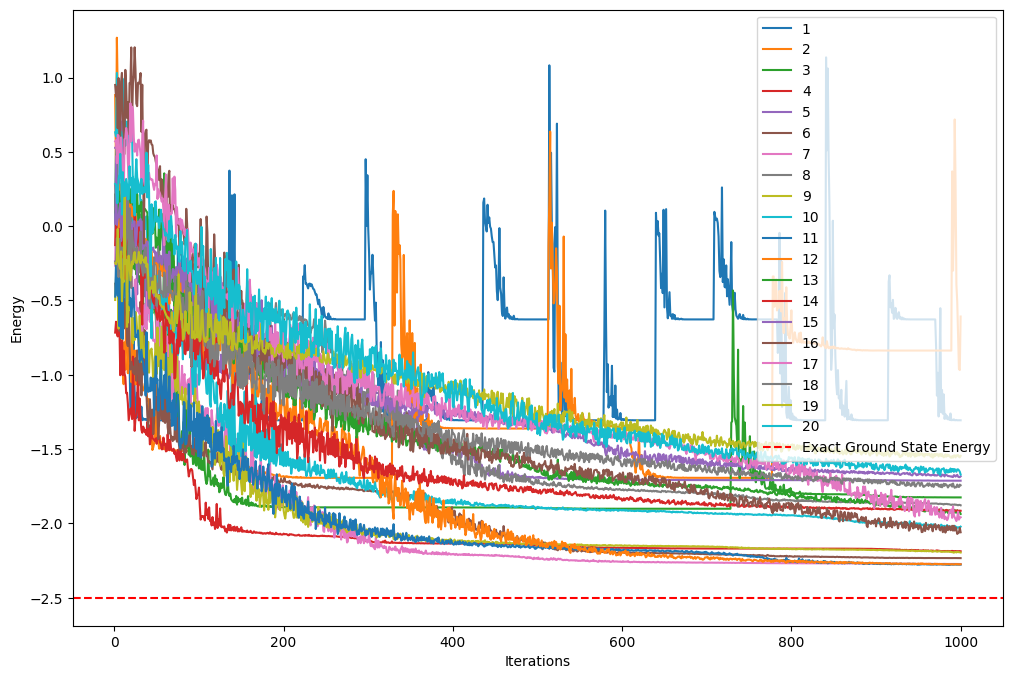

In [24]:
plt.clf()
# Plot energy vs iterations for each algorithm and initialization on a single chart
plt.figure(figsize=(12, 8))
for layer in range(1, MAX_LAYERS+1):
    # Filter results for specific algorithm and initialization
    filtered_results_df = results_df[
        (results_df['algo'] == layer)
    ]
    # Plot energy vs iterations
    plt.plot(
        filtered_results_df['eval_count'],
        filtered_results_df['energy'],
        label=f"{layer}",
    )
    
plt.axhline(
        y=exact_result.eigenvalue.real,
        color='r',
        linestyle='--',
        label='Exact Ground State Energy',
    )

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

In [11]:
results_df.to_csv("d-evals.csv")